# Proyecto Final
## ISWZ3401-01 Inteligencia Artificial I
### Diego Hiriart, Luis Corales

In [7]:
#Necessary modules import
import pathlib
import os

import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import io
import scipy.misc
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from six.moves.urllib.request import urlopen
import wget
import tarfile
import zipfile

import tensorflow as tf#needs protobuf 3.20.1 or lower for Tensorflow's tutorial

tf.get_logger().setLevel('ERROR')

# Load datasets

In [2]:
#Import training images
#https://www.kaggle.com/datasets/sachinpatel21/pothole-image-dataset
dataDir = 'C:\Code-UDLA\AI I\Proyecto Final\data\pothole_image_data'
trainingDataset = tf.keras.utils.image_dataset_from_directory(directory=dataDir, validation_split=0.3, subset="training", seed=123)
validationDataset = tf.keras.utils.image_dataset_from_directory(directory=dataDir, validation_split=0.3, subset="validation", seed=123)
classNames = trainingDataset.class_names
print("Classes in datasets: {0}".format(classNames))

Found 618 files belonging to 1 classes.
Using 433 files for training.
Found 618 files belonging to 1 classes.
Using 185 files for validation.
Classes in datasets: ['pothole']


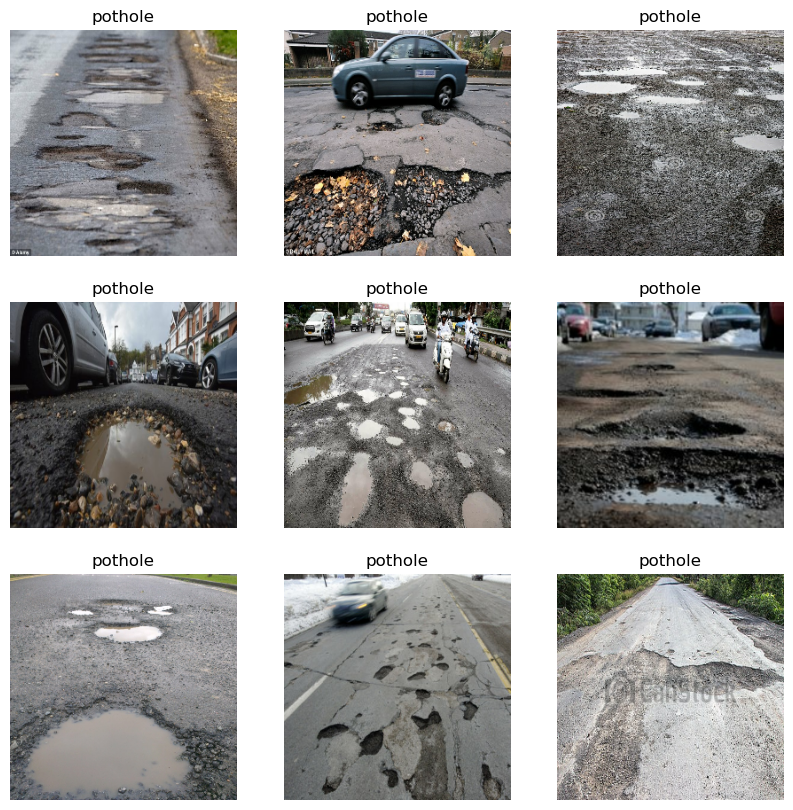

In [3]:
#View some images
plt.figure(figsize=(10, 10))
for images, labels in trainingDataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classNames[labels[i]])
    plt.axis("off")

# Create utilities
- Start the object detection part, see this tutorial as reference [TensorFlow Hub Object Detection ColabTensorFlow Hub Object Detection Colab](https://www.tensorflow.org/hub/tutorials/tf2_object_detection)
- First, some utilities must be created. These will not be used later when the model is only used to recognize potholes

In [26]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  image = None
  if(path.startswith('http')):
    response = urlopen(path)
    image_data = response.read()
    image_data = BytesIO(image_data)
    image = Image.open(image_data)
  else:
    image_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(image_data))

  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)


ALL_MODELS = {
'CenterNet HourGlass104 512x512' : 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512/1',
'CenterNet HourGlass104 Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512_kpts/1',
'CenterNet HourGlass104 1024x1024' : 'https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024/1',
'CenterNet HourGlass104 Keypoints 1024x1024' : 'https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024_kpts/1',
'CenterNet Resnet50 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512/1',
'CenterNet Resnet50 V1 FPN Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512_kpts/1',
'CenterNet Resnet101 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet101v1_fpn_512x512/1',
'CenterNet Resnet50 V2 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512/1',
'CenterNet Resnet50 V2 Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512_kpts/1',
'EfficientDet D0 512x512' : 'https://tfhub.dev/tensorflow/efficientdet/d0/1',
'EfficientDet D1 640x640' : 'https://tfhub.dev/tensorflow/efficientdet/d1/1',
'EfficientDet D2 768x768' : 'https://tfhub.dev/tensorflow/efficientdet/d2/1',
'EfficientDet D3 896x896' : 'https://tfhub.dev/tensorflow/efficientdet/d3/1',
'EfficientDet D4 1024x1024' : 'https://tfhub.dev/tensorflow/efficientdet/d4/1',
'EfficientDet D5 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d5/1',
'EfficientDet D6 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d6/1',
'EfficientDet D7 1536x1536' : 'https://tfhub.dev/tensorflow/efficientdet/d7/1',
'SSD MobileNet v2 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2',
'SSD MobileNet V1 FPN 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v1/fpn_640x640/1',
'SSD MobileNet V2 FPNLite 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1',
'SSD MobileNet V2 FPNLite 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_640x640/1',
'SSD ResNet50 V1 FPN 640x640 (RetinaNet50)' : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_640x640/1',
'SSD ResNet50 V1 FPN 1024x1024 (RetinaNet50)' : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_1024x1024/1',
'SSD ResNet101 V1 FPN 640x640 (RetinaNet101)' : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_640x640/1',
'SSD ResNet101 V1 FPN 1024x1024 (RetinaNet101)' : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_1024x1024/1',
'SSD ResNet152 V1 FPN 640x640 (RetinaNet152)' : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_640x640/1',
'SSD ResNet152 V1 FPN 1024x1024 (RetinaNet152)' : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_1024x1024/1',
'Faster R-CNN ResNet50 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1',
'Faster R-CNN ResNet50 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_1024x1024/1',
'Faster R-CNN ResNet50 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_800x1333/1',
'Faster R-CNN ResNet101 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_640x640/1',
'Faster R-CNN ResNet101 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_1024x1024/1',
'Faster R-CNN ResNet101 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_800x1333/1',
'Faster R-CNN ResNet152 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_640x640/1',
'Faster R-CNN ResNet152 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_1024x1024/1',
'Faster R-CNN ResNet152 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_800x1333/1',
'Faster R-CNN Inception ResNet V2 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_640x640/1',
'Faster R-CNN Inception ResNet V2 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_1024x1024/1',
'Mask R-CNN Inception ResNet V2 1024x1024' : 'https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1'
}

IMAGES_FOR_TEST = {
  'Beach' : 'object_detection/test_images/image2.jpg',
  'Dogs' : 'object_detection/test_images/image1.jpg',
  # By Heiko Gorski, Source: https://commons.wikimedia.org/wiki/File:Naxos_Taverna.jpg
  'Naxos Taverna' : 'https://upload.wikimedia.org/wikipedia/commons/6/60/Naxos_Taverna.jpg',
  # Source: https://commons.wikimedia.org/wiki/File:The_Coleoptera_of_the_British_islands_(Plate_125)_(8592917784).jpg
  'Beatles' : 'https://upload.wikimedia.org/wikipedia/commons/1/1b/The_Coleoptera_of_the_British_islands_%28Plate_125%29_%288592917784%29.jpg',
  # By Américo Toledano, Source: https://commons.wikimedia.org/wiki/File:Biblioteca_Maim%C3%B3nides,_Campus_Universitario_de_Rabanales_007.jpg
  'Phones' : 'https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg/1024px-Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg',
  # Source: https://commons.wikimedia.org/wiki/File:The_smaller_British_birds_(8053836633).jpg
  'Birds' : 'https://upload.wikimedia.org/wikipedia/commons/0/09/The_smaller_British_birds_%288053836633%29.jpg',
  'Pothole': 'data/pothole_image_data/pothole/109.jpg',
}

COCO17_HUMAN_POSE_KEYPOINTS = [(0, 1),
 (0, 2),
 (1, 3),
 (2, 4),
 (0, 5),
 (0, 6),
 (5, 7),
 (7, 9),
 (6, 8),
 (8, 10),
 (5, 6),
 (5, 11),
 (6, 12),
 (11, 12),
 (11, 13),
 (13, 15),
 (12, 14),
 (14, 16)]

# Install TF object detection
- Install Tensorflow's object detection API, using protocol builder to compile the models.\
- To do that, you need to clone or download https://github.com/tensorflow/models, and use the protos, packages, utils, and core folders from research/object_detection. 
- Then, run: `protoc object_detection/protos/*.proto --python_out=.` in the project folder. The utils and core folders are used later. Protocol bbuffers (protoc) can be found here https://github.com/protocolbuffers/protobuf/releases/tag/v21.10
- After compiling, run `copy object_detection\packages\tf2\setup.py .` and `python -m pip install .` as administrator.

Now, import object detection dependencies

In [9]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops

#Makes plot outputs be stored with the notebook. Must be commented if on a script
%matplotlib inline

# Load object labels to be used

In [31]:
PATH_TO_LABELS = 'data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

# Save (serialize) and load (deserialize) model
So that we can save the trained model and use it quickly

In [10]:
def saveModel(model):
    modelSavingPath = '.\detection-model'
    tf.saved_model.save(model, modelSavingPath)
    return

def loadModel(path):
    model = tf.saved_model.load(path)
    return model

# Select and load a pre-existing model from Tensorflow's repo 
It is normal to get a bunch of function importing warnings when loading the model, as long as it loads

In [7]:
model_display_name = 'CenterNet HourGlass104 Keypoints 512x512'
modelDownloadURL = ALL_MODELS[model_display_name]+"?tf-hub-format=compressed"

print('Selected model:'+ model_display_name)
print('Model Handle at TensorFlow Hub: {}'.format(modelDownloadURL))

Selected model:CenterNet HourGlass104 Keypoints 512x512
Model Handle at TensorFlow Hub: https://tfhub.dev/tensorflow/centernet/hourglass_512x512_kpts/1?tf-hub-format=compressed


In [15]:
#Download model and save it, only needed once since it can be reloaded from local files later
print("Downloading model file...")
modelFileName = model_display_name.replace(' ', '_')+".tar.gz"
if os.path.exists(modelFileName):
    os.remove(modelFileName)
wget.download(modelDownloadURL, modelFileName)
print("\nModel file downloaded!")
print("Extracting model...")
tarFile = tarfile.open(modelFileName)
extractionPath = '.\hub-model'
tarFile.extractall(extractionPath) # specify which folder to extract to
tarFile.close()
print("Model extracted!")
print('Loading model...')
objectRecogModel = loadModel(extractionPath)
print('Model loaded!')

100% [......................................................................] 728311630 / 728311630Model file downloaded!
Extracting model...
Model extracted!
Loading model...


Model loaded!


# Train the model and save it
Re-train the model so it only recognizes potholes, then save it. Warnings may be displayed

In [17]:
#Training
#Save model
saveModel(objectRecogModel)

# Recover the trained model
There may be a bunch of function importing related warnings, this is normal

In [13]:
modelPath = '.\detection-model'
print("Loading model...")
objectRecogModel = loadModel(modelPath)
print("Model loading done")

Loading model...


Model loading done


# Create functions to do the inference (recognize objects) and view results
- To recognize objects and view results, code form the Tensorflow tutorial was followed.
- Inorder to use live video input and view results, this tutorial was followed [Adapting to video feed - TensorFlow Object Detection API Tutorial p.2](https://www.youtube.com/watch?v=MyAOtvwTkT0&list=PLQVvvaa0QuDcNK5GeCQnxYnSSaar2tpku&index=2) or [Streaming Object Detection Video - Tensorflow Object Detection API Tutorial](https://pythonprogramming.net/video-tensorflow-object-detection-api-tutorial/)

In [16]:
def recognizeObjectsImage(model, image_np):
    # running inference
    results = model(image_np)

    # different object detection models have additional results
    # all of them are explained in the documentation
    result = {key:value.numpy() for key,value in results.items()}
    print(result.keys())
    return result

def viewResultsImage(result, image_np):
    label_id_offset = 0
    image_np_with_detections = image_np.copy()

    # Use keypoints if available in detections
    keypoints, keypoint_scores = None, None
    if 'detection_keypoints' in result:
      keypoints = result['detection_keypoints'][0]
      keypoint_scores = result['detection_keypoint_scores'][0]

    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections[0],
          result['detection_boxes'][0],
          (result['detection_classes'][0] + label_id_offset).astype(int),
          result['detection_scores'][0],
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=200,
          min_score_thresh=.30,
          agnostic_mode=False,
          keypoints=keypoints,
          keypoint_scores=keypoint_scores,
          keypoint_edges=COCO17_HUMAN_POSE_KEYPOINTS)

    plt.figure(figsize=(24,32))
    plt.imshow(image_np_with_detections[0])
    plt.show()
    return

def recognizeAndViewObjectsVideo(model):
    #Start video capture
    liveCapture = cv2.VideoCapture(0)
    # running inference
    while True:
        ret, image_np = liveCapture.read()#Read images from cv2's live video catpure
        
        # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
        image_np_expanded = np.expand_dims(image_np, axis=0)
        
        # running inference
        results = model(image_np_expanded)
        # different object detection models have additional results
        # all of them are explained in the documentation
        result = {key:value.numpy() for key,value in results.items()}
        
        #Visualization
        label_id_offset = 0
        # Use keypoints if available in detections
        keypoints, keypoint_scores = None, None
        viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_expanded[0],
          result['detection_boxes'][0],
          (result['detection_classes'][0] + label_id_offset).astype(int),
          result['detection_scores'][0],
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=200,
          min_score_thresh=.30,
          agnostic_mode=False,
          keypoints=keypoints,
          keypoint_scores=keypoint_scores,
          keypoint_edges=COCO17_HUMAN_POSE_KEYPOINTS)
        
        cv2.imshow('object detection', cv2.resize(image_np, (800,600)))
        if cv2.waitKey(25) & 0xFF == ord('q'):
            cv2.destroyAllWindows()
            break

# Testing with a sample image
Test the model with an existing image from the repo, needs the test_images folder from object_detection

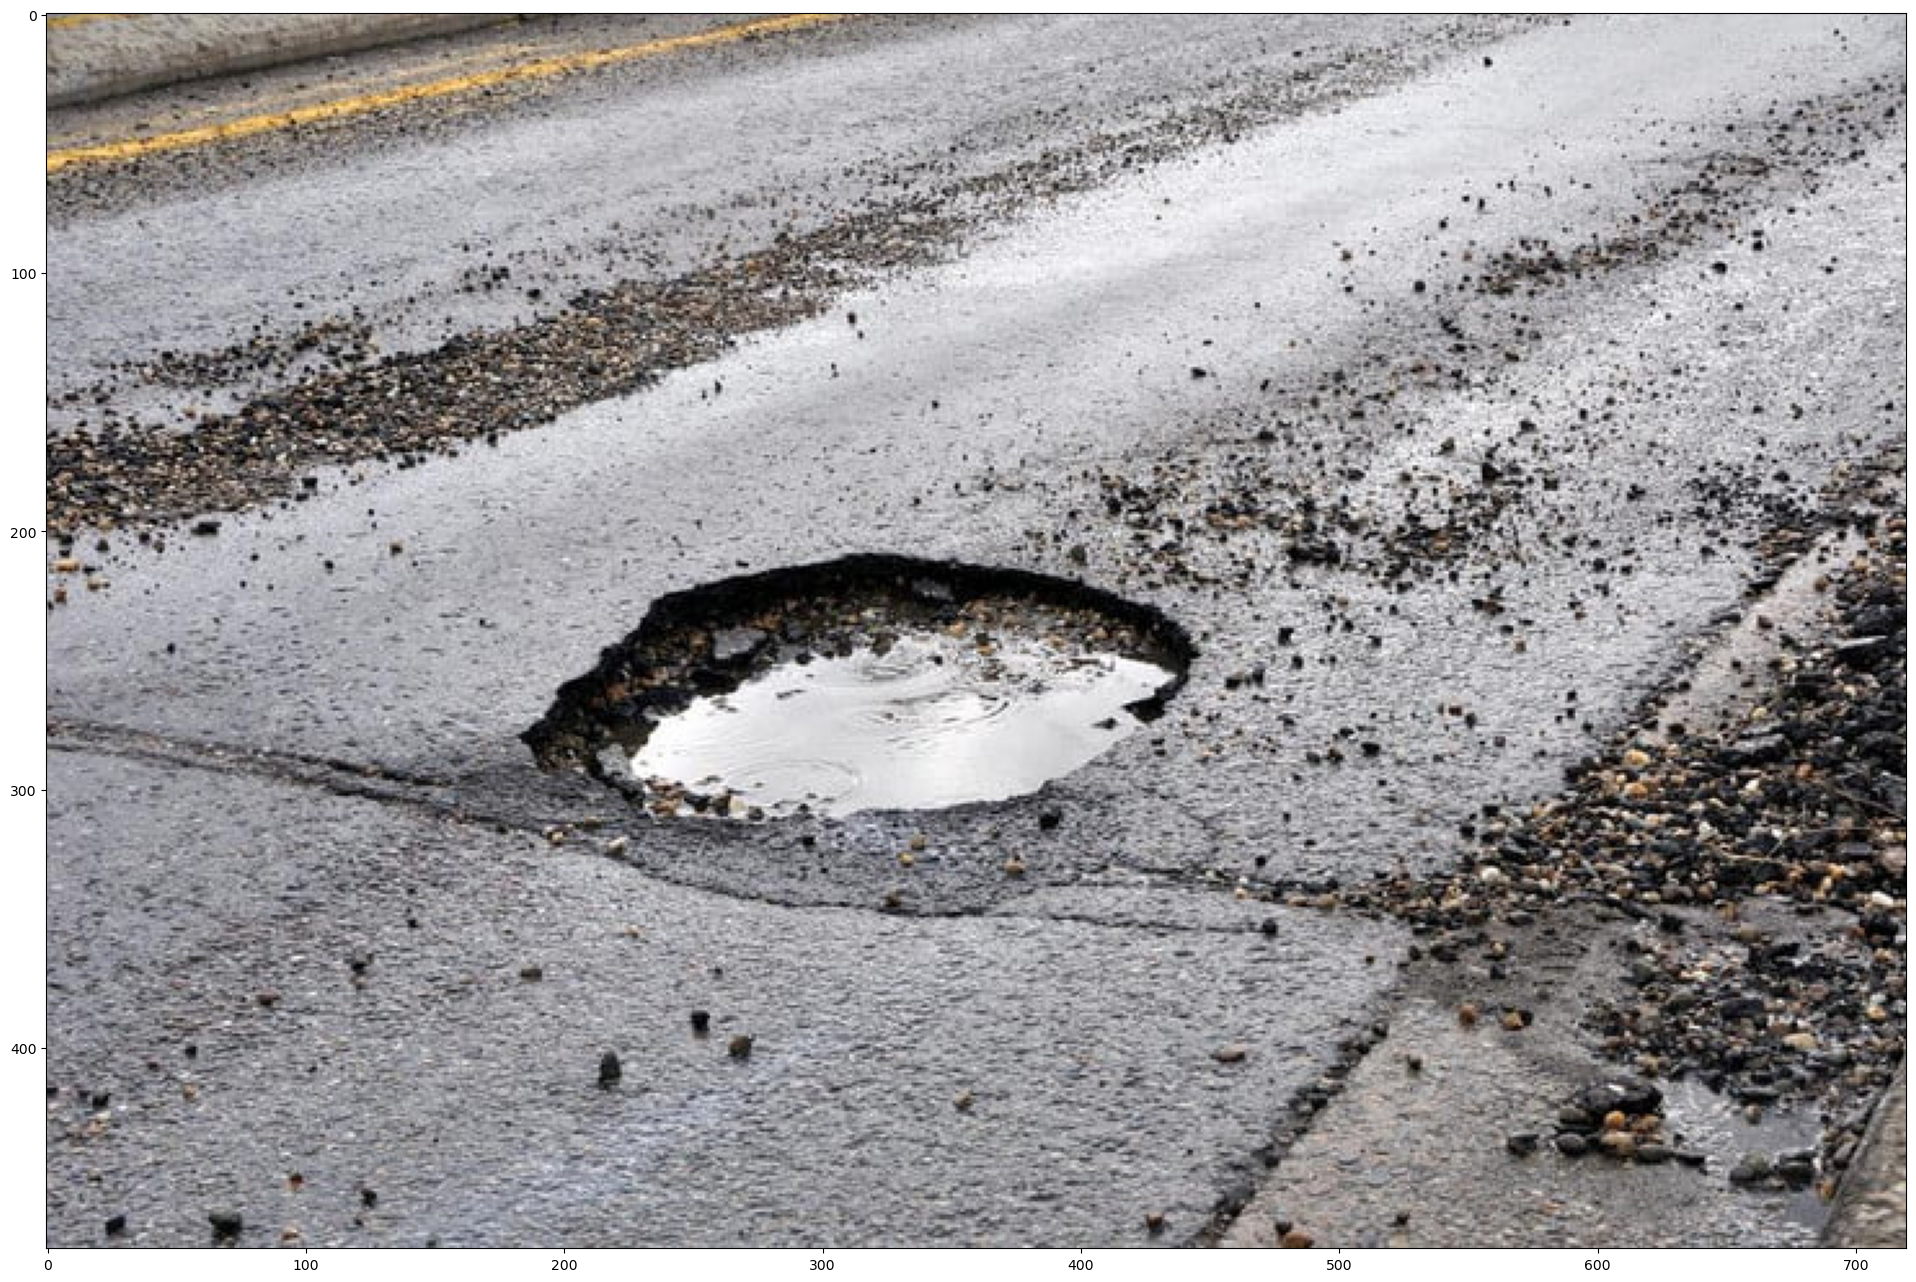

In [41]:
selected_image = 'Pothole' # @param ['Beach', 'Dogs', 'Naxos Taverna', 'Beatles', 'Phones', 'Birds', 'Pothole']
flip_image_horizontally = False
convert_image_to_grayscale = False

image_path = IMAGES_FOR_TEST[selected_image]
image_np = load_image_into_numpy_array(image_path)

# Flip horizontally
if(flip_image_horizontally):
  image_np[0] = np.fliplr(image_np[0]).copy()

# Convert image to grayscale
if(convert_image_to_grayscale):
  image_np[0] = np.tile(
    np.mean(image_np[0], 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

plt.figure(figsize=(24,32))
plt.imshow(image_np[0])
plt.show()

Call inference and results visualization functions

dict_keys(['detection_keypoint_scores', 'num_detections', 'detection_boxes', 'detection_keypoints', 'detection_scores', 'detection_classes'])


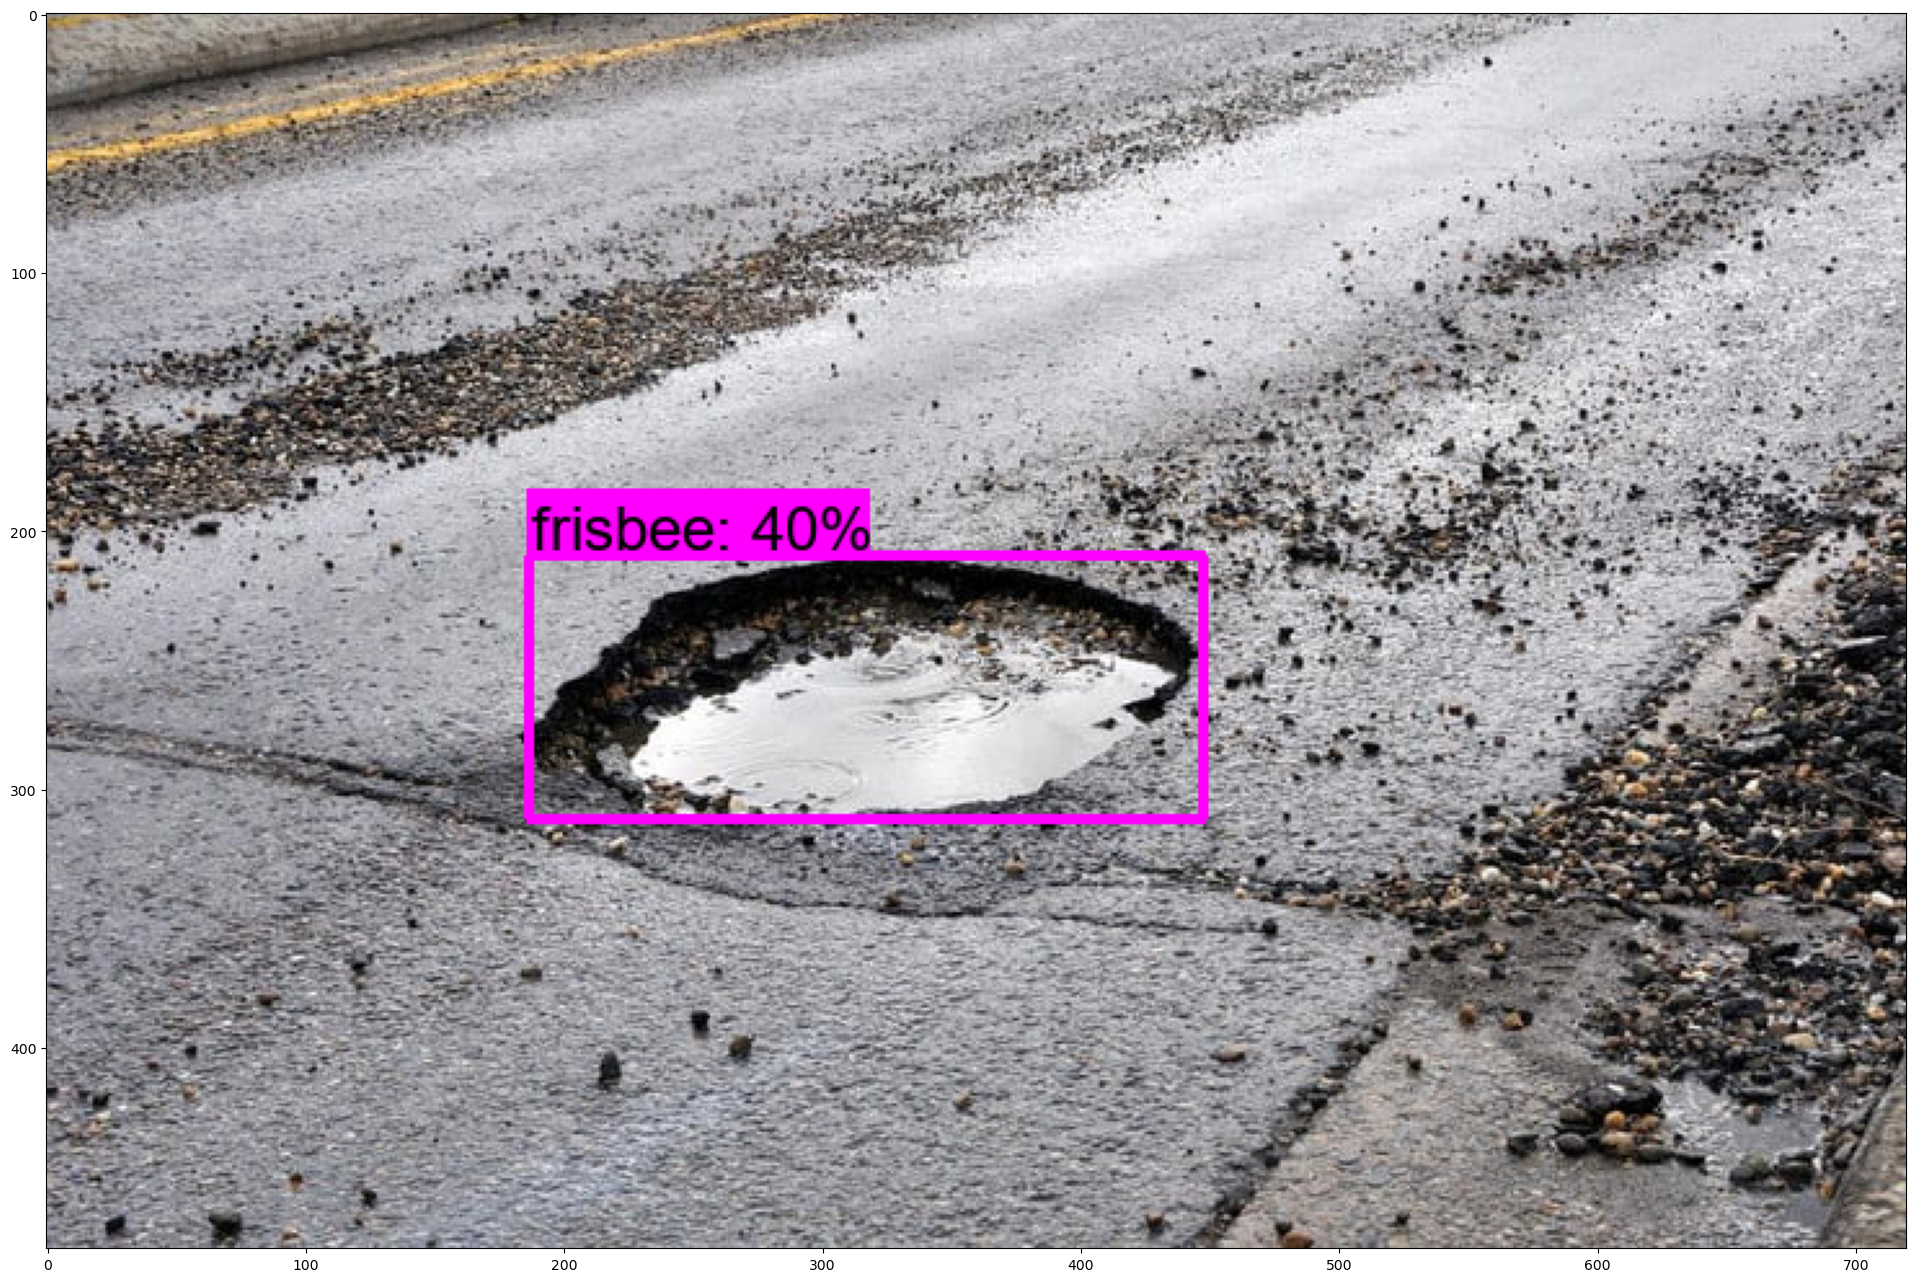

In [42]:
results = recognizeObjectsImage(objectRecogModel, image_np)
viewResultsImage(results, image_np)

# Testing with live video feed

In [ ]:
recognizeAndViewObjectsVideo(objectRecogModel)